# Анализ устойчивости ИП в Казахстане по данным от 2018 года.



Нам нужно исследовать устойчивость индивидуальных предпринимателей (ИП) в Казахстане, выявив факторы, влияющие на их закрытие, и построить модель прогнозирования рисков (факторы закрытия ип). Дать рекомендации для малого бизнеса по окончанию исследования.

Мы работаем  с данными, опубликованными о ИП от 2018 г.

# Описание данных



Таблица `IP` содержит информацию о ИП с их параметрами c 2018 г.

- ОКЭД – Общий Классификатор Видов Экономической Деятельности (классифицирует виды предпринимательской деятельности)
- КРП – код числа работников (малые, средние, много)
- КАТО – код места регистрации
- cut_date – дата когда ИП был последний раз зафиксирован с таким набором параметров
- age – возраст, лет	
- gender - пол	
- БИН_код – закодированный ИИН ИП 

Таблица `IP_matrix` содержит информацию по ИП на отчетный месяц

- age – срок регистрации 	
- gender - пол	
- БИН_код – закодированный ИИН ИП
- Отчетный период

**Если ИП имел ранее 1 и потом возник 0, то это означает, что ИП закрылся**

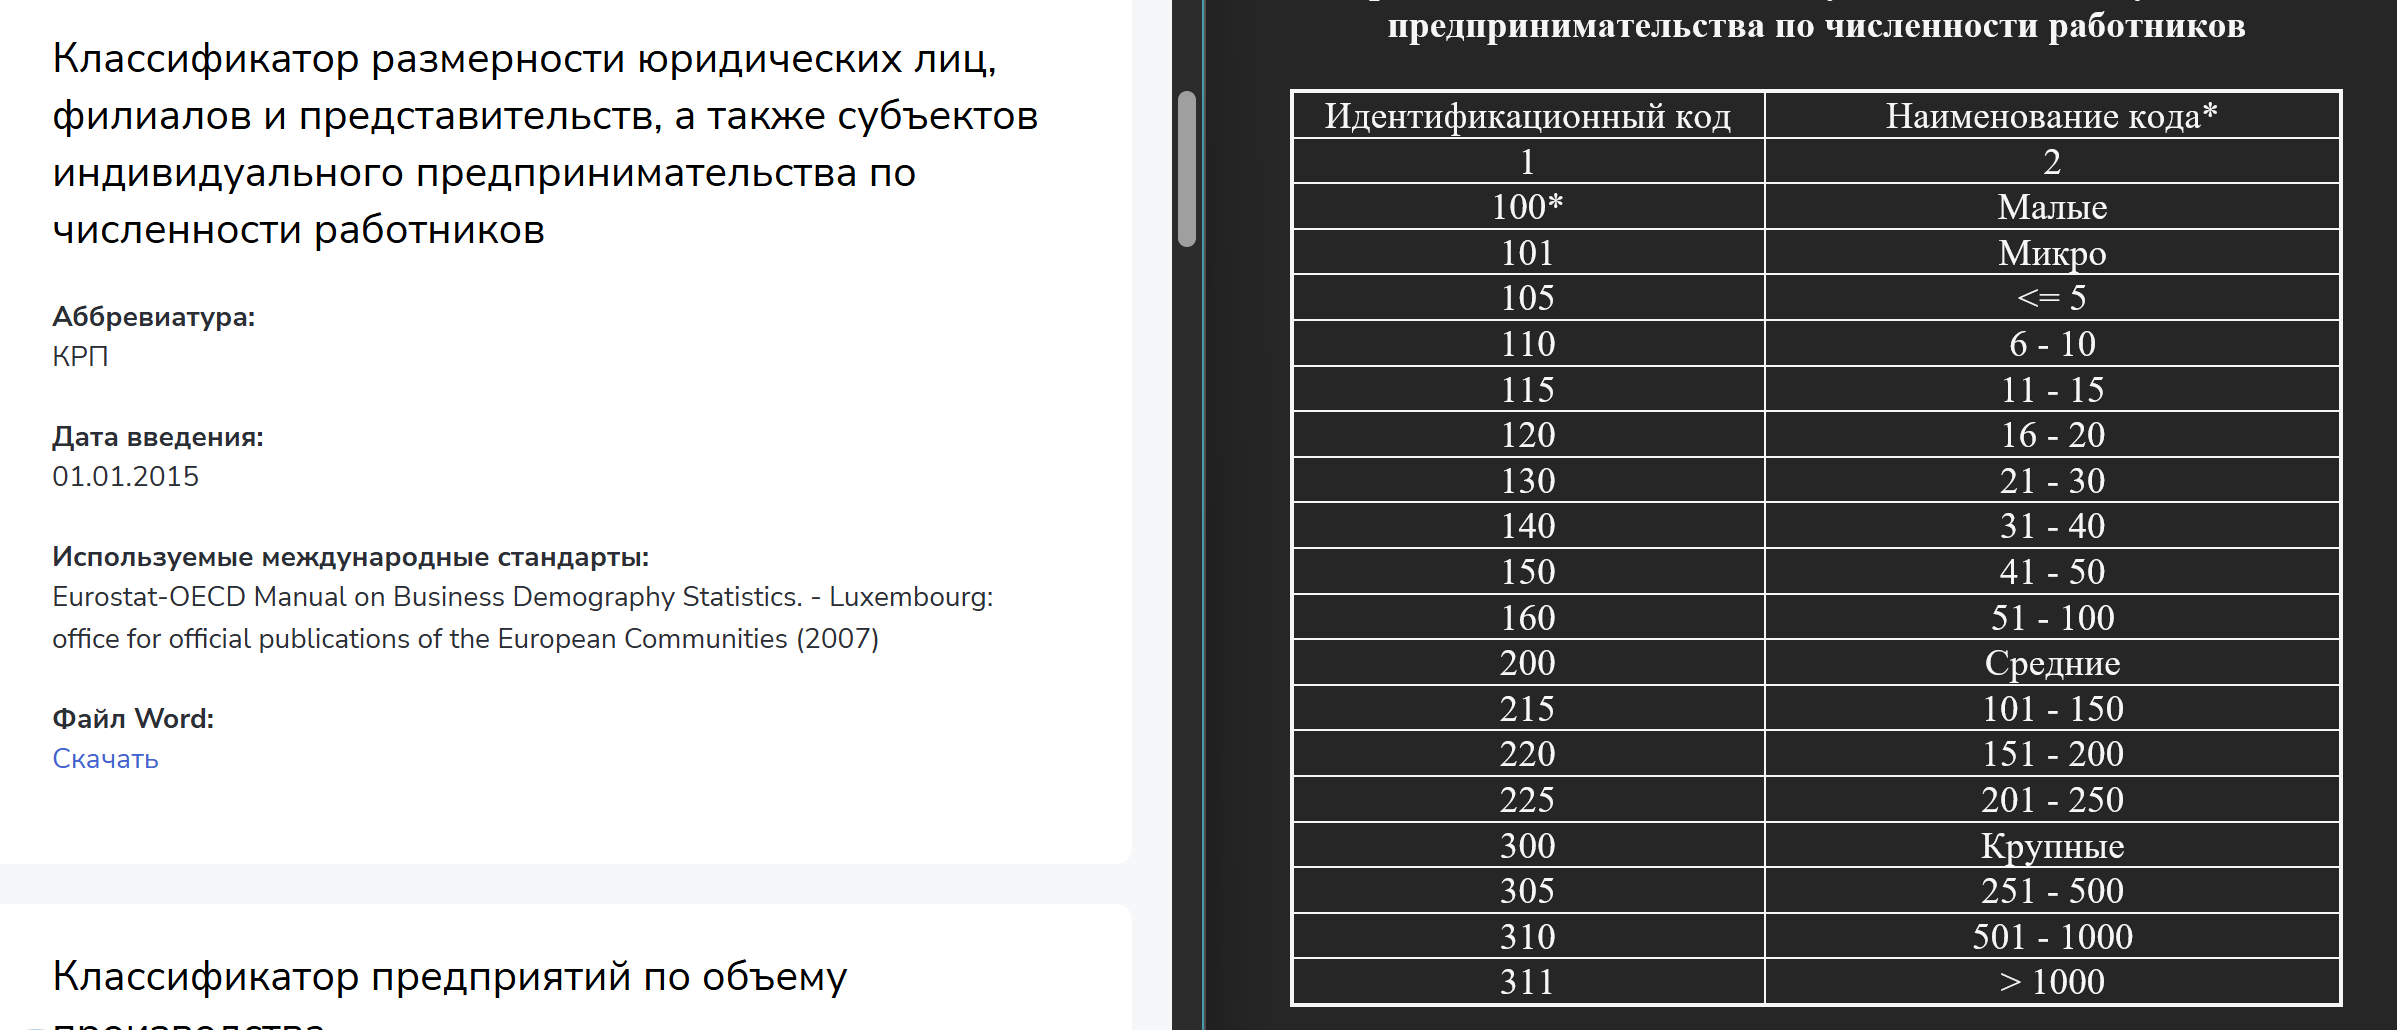

## Предобработка данных 

### Импортирование нужных библиотек и функций, инструментов

In [1]:
#импорты базовые
import numpy as np
import pandas as pd 
from datetime import datetime
#импорты визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

#обучение модели
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import logging
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

😀 😁 😂 🤣 😊 😍 😎 😜 😔 😢 😳 😡 😤 🐶 🐱 🐸 🐰 🦁 🦄 🦉 🚗 🚀 🚲 ✈️ 🚂 🌞 🌧️ 🌈 🌻 🌵 🍎 🍕 🍔 🍩 🍣 🍺 ☕ ❤️ 💡 🔥 ⭐ 💀 ✅ 🛑 💻 📱 🖥️ 🖱️ 🔧 🔋 ⚽ 🏀 🏈 🏋️‍♂️ 🧘‍♀️ 🏆

### Чтение данных и первичный осмотр

In [2]:
#Чтение данный и первичный осмотр
try:
    data = pd.read_csv('IP.csv')
    print('Загрузка локально 💻')
except FileNotFoundError:
    print('Загрузка не удалась')

data.head()

Загрузка локально 💻


,ОКЭД,КРП,КАТО,cut_date,age,gender,БИН_код
0,47999,105,103620200,2024-05-01,26,0,1
1,47910,105,103620100,2024-05-01,59,0,2
2,47822,105,103620100,2024-05-01,65,0,3
3,47910,105,103620100,2024-05-01,74,0,4
4,10710,105,103620100,2024-05-01,41,0,5


In [3]:
# Посмотрим полностью информацию по каждому столбцу через методы инфо и дискрайб
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515178 entries, 0 to 4515177
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   ОКЭД      int64 
 1   КРП       int64 
 2   КАТО      int64 
 3   cut_date  object
 4   age       int64 
 5   gender    int64 
 6   БИН_код   int64 
dtypes: int64(6), object(1)
memory usage: 241.1+ MB


🚀 Выводы:
 1. Колонкам с кодами по описанию присвоить категории, так как это коды
 2. cut_date привезти к типу datatime  и возможно после добавить признаки по сезоннности
 3. проверить кодировку кодов (чтобы оставить в данном виде)

In [4]:
#изменяю тип данных 
for col in ['ОКЭД', 'КРП', 'КАТО']:
    data[col] = data[col].astype('category')
    
data['cut_date'] = pd.to_datetime(data['cut_date'])

#даты мин и макс времени
min_date = data['cut_date'].min()
max_date = data['cut_date'].max()

print(f"Минимальная дата в датасете: {min_date}")
print(f"Максимальная дата в датасете: {max_date}")

Минимальная дата в датасете: 2018-01-01 00:00:00
Максимальная дата в датасете: 2024-05-01 00:00:00


🚀 Данные были все выгружены в разные дни.

In [5]:
#Чтение данный и первичный осмотр второй таблицы
try:
    data_2 = pd.read_csv('IP_matrix.csv')
    print('Загрузка локально 💻')
except FileNotFoundError:
    print('Загрузка не удалась')

data_2.head()

Загрузка локально 💻


,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,...,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,gender,age_bin,БИН_код
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,-1,1,1069055
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,-1,1,587657
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,1,2452689
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,-1,1,1840313
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,-1,1,1370674


In [6]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009649 entries, 0 to 3009648
Data columns (total 80 columns):
 #   Column      Dtype
---  ------      -----
 0   2018-01-01  int64
 1   2018-02-01  int64
 2   2018-03-01  int64
 3   2018-04-01  int64
 4   2018-05-01  int64
 5   2018-06-01  int64
 6   2018-07-01  int64
 7   2018-08-01  int64
 8   2018-09-01  int64
 9   2018-10-01  int64
 10  2018-11-01  int64
 11  2018-12-01  int64
 12  2019-01-01  int64
 13  2019-02-01  int64
 14  2019-03-01  int64
 15  2019-04-01  int64
 16  2019-05-01  int64
 17  2019-06-01  int64
 18  2019-07-01  int64
 19  2019-08-01  int64
 20  2019-09-01  int64
 21  2019-10-01  int64
 22  2019-11-01  int64
 23  2019-12-01  int64
 24  2020-01-01  int64
 25  2020-02-01  int64
 26  2020-03-01  int64
 27  2020-04-01  int64
 28  2020-05-01  int64
 29  2020-06-01  int64
 30  2020-07-01  int64
 31  2020-08-01  int64
 32  2020-09-01  int64
 33  2020-10-01  int64
 34  2020-11-01  int64
 35  2020-12-01  int64
 36  2021-01-

🚀 Замечен интересный факт, что количество уникальных значений `data['сut_data']` 77 совпадает с количеством колонок в таблице `IP_matrix`с датой 77

Достать из данных:
1. Открые ИП
2. Закрытые ИП
3. Дата записи ИП (переход с 0 в 1)
4. Дата закрытия ИП (переход с 1 в 0)

🛑 😳 **Данные большие и занимают очень много памяти, если выгружать целиком и делать преобразования**

- фнукция melt с разбиением не работает 
- сразу выгружать с разбиением не работает
- через библиотеку dask не работает
- через создания базы sqlite не работает

🚀 Работаем с такой таблицей. Достанем закрытые ИП (переход с 1 в 0), открытые ИП (1), дата по которой у нас закрылись ИП и дату записи ИП в базе.

**Закрытые ИП :**

In [7]:
# логирование
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()  # Вывод в консоль
    ]
)

# столбцы с датами 
logging.info("Инициализация списка столбцов с датами")
date_columns = [col for col in data_2.columns if col not in ['gender', 'age_bin', 'БИН_код']]

# даты активации и закрытия
def find_dates(row, date_columns):
    activation_month = None
    closure_month = None
    
    # первый 0 в 1 или первый месяц  1)
    for i in range(len(date_columns)):
        if row[date_columns[i]] == 1:
            if i == 0 or row[date_columns[i-1]] == 0:
                activation_month = date_columns[i]
            break  # останавливаем нашли
    
    # переход 1 в 0
    for i in range(len(date_columns) - 1):
        if row[date_columns[i]] == 1 and row[date_columns[i + 1]] == 0:
            closure_month = date_columns[i + 1]
            break
    
    return activation_month, closure_month

# Функция для обработки одной строки
def process_row(index, row, date_columns):
    return index, *find_dates(row, date_columns)

# Параллельная обработка с прогресс-баром
logging.info("Начало параллельной обработки строк")
tqdm.pandas()

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(
    delayed(process_row)(i, row, date_columns)
    for i, row in tqdm(data_2.iterrows(), total=len(data_2), desc="Обработка ИП")
)

# колонки в DataFrame
data_2['data_create'] = pd.Series({idx: act for idx, act, _ in results})
data_2['close_date'] = pd.Series({idx: close for idx, _, close in results})

# Фильтруем закрытые ИП (где есть close_date)
logging.info("Фильтрация закрытых ИП")
closed_ips = data_2[data_2['close_date'].notnull()]

# итоговая таблица
close_ip = closed_ips[['gender', 'age_bin', 'БИН_код', 'data_create', 'close_date']]


#  первые строки для проверки
logging.info("Первые 5 строк результата:")
print(close_ip.head())

logging.info(f"Обработка завершена. Найдено {len(close_ip)} закрытых ИП")

2025-07-11 16:46:17,821 - INFO - Инициализация списка столбцов с датами
2025-07-11 16:46:17,822 - INFO - Начало параллельной обработки строк
Обработка ИП: 100%|███████████████████████████████████████████████████████| 3009649/3009649 [04:11<00:00, 11983.52it/s]
2025-07-11 16:50:31,398 - INFO - Фильтрация закрытых ИП
2025-07-11 16:50:31,907 - INFO - Первые 5 строк результата:
2025-07-11 16:50:31,909 - INFO - Обработка завершена. Найдено 1720954 закрытых ИП


   gender  age_bin  БИН_код data_create  close_date
2      -1        1  2452689  2021-09-01  2022-02-01
3      -1        1  1840313  2022-08-01  2024-02-01
5      -1        1  1962670  2022-08-01  2023-12-01
7      -1        1  1420141  2021-05-01  2021-06-01
8      -1        1  2486118  2021-10-01  2021-12-01


In [8]:
close_ip.head()

,gender,age_bin,БИН_код,data_create,close_date
2,-1,1,2452689,2021-09-01,2022-02-01
3,-1,1,1840313,2022-08-01,2024-02-01
5,-1,1,1962670,2022-08-01,2023-12-01
7,-1,1,1420141,2021-05-01,2021-06-01
8,-1,1,2486118,2021-10-01,2021-12-01


**Открытые ИП:**

In [9]:
# список столбцов с датами
logging.info("Инициализация списка столбцов с датами")
date_columns = [col for col in data_2.columns if col not in ['gender', 'age_bin', 'БИН_код']]

# определение статуса ИП и даты создания
def get_ip_status(row, date_columns):
    is_open = True  # По умолчанию считаем ИП открытым
    data_create = 'unknown'  # создание по умолчанию
    
    # первый переход 0 в 1 или первый месяц с 1
    for i in range(len(date_columns)):
        if row[date_columns[i]] == 1:
            if i == 0 or row[date_columns[i-1]] == 0:
                data_create = date_columns[i]
            break 
    
    # переход 1 в 0 
    for i in range(len(date_columns) - 1):
        if row[date_columns[i]] == 1 and row[date_columns[i + 1]] == 0:
            is_open = False
            break
    
    return is_open, data_create

# Функция для обработки одной строки
def process_row(index, row, date_columns):
    return index, *get_ip_status(row, date_columns)

# Параллельная обработка с прогресс-баром
logging.info("Начало параллельной обработки строк")
tqdm.pandas() 

# Получаем количество доступных ядер процессора
num_cores = multiprocessing.cpu_count()

# Параллельное выполнение функции для каждой строки
results = Parallel(n_jobs=num_cores)(
    delayed(process_row)(i, row, date_columns)
    for i, row in tqdm(data_2.iterrows(), total=len(data_2), desc="Обработка строк")
)

# результаты сохраняем
data_2['is_open'] = pd.Series({index: status for index, status, _ in results})
data_2['data_create'] = pd.Series({index: date for index, _, date in results})

# где is_open == True
logging.info("Фильтрация открытых ИП")
open_ips = data_2[data_2['is_open']]

# итоговая таблица
logging.info("Формирование итоговой таблицы")
open_ip = open_ips[['gender', 'age_bin', 'БИН_код', 'data_create']]

# Выводим первые строки результата для проверки
logging.info("Вывод первых строк результата")
print(open_ip.head())

logging.info("Обработка завершена")

2025-07-11 16:50:31,936 - INFO - Инициализация списка столбцов с датами
2025-07-11 16:50:31,937 - INFO - Начало параллельной обработки строк
Обработка строк: 100%|█████████████████████████████████████████████████████| 3009649/3009649 [08:37<00:00, 5813.83it/s]
2025-07-11 16:59:12,613 - INFO - Фильтрация открытых ИП
2025-07-11 16:59:13,018 - INFO - Формирование итоговой таблицы
2025-07-11 16:59:13,051 - INFO - Вывод первых строк результата
2025-07-11 16:59:13,051 - INFO - Обработка завершена


   gender  age_bin  БИН_код data_create
0      -1        1  1069055  2023-11-01
1      -1        1   587657  2023-08-01
4      -1        1  1370674  2023-05-01
6      -1        1  1141066  2024-01-01
9      -1        1    61026  2023-04-01


In [10]:
open_ip.head()

,gender,age_bin,БИН_код,data_create
0,-1,1,1069055,2023-11-01
1,-1,1,587657,2023-08-01
4,-1,1,1370674,2023-05-01
6,-1,1,1141066,2024-01-01
9,-1,1,61026,2023-04-01


🚀 Количество закрытых ИП составляет на период с 2018 г. по 2024 г. - 1 720 954 шт., Количество открытых ИП составляет - 1 288 695 шт.

In [11]:
open_ip.info()

close_ip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1288695 entries, 0 to 3009646
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   gender       1288695 non-null  int64 
 1   age_bin      1288695 non-null  int64 
 2   БИН_код      1288695 non-null  int64 
 3   data_create  1288695 non-null  object
dtypes: int64(3), object(1)
memory usage: 49.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1720954 entries, 2 to 3009648
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   gender       int64 
 1   age_bin      int64 
 2   БИН_код      int64 
 3   data_create  object
 4   close_date   object
dtypes: int64(3), object(2)
memory usage: 78.8+ MB


🚀 **Вывод по первичному осмотру:**

   1. Изменить тип данных в таблицах  (коды - категория, дата  - дата)
   2. Таблицу IP_matrix разделила на две (закрытые ИП 1 720 954 и открытые ИП 1 288 695) для дальнейшей маркировки и обучения
   3. Дисбаланса классов есть, но он не критичный  

### Пропущенные значения, уникальные значения, дубликаты и аномалии 

**Таблица data**

In [12]:
#посмотрим на все пропущенные значения
null_columns = data.columns
def data_null(data, column):
    for col in column:
        print(f'Процент пропуска {col} от всего датасета = {((data[col].isnull().sum())/ data.shape[0])*100}')
        print(f'Количество уникальных значений в колонке {col}: {len(data[col].unique())}')
        print()
data_null(data,null_columns)

Процент пропуска ОКЭД от всего датасета = 0.0
Количество уникальных значений в колонке ОКЭД: 1140

Процент пропуска КРП от всего датасета = 0.0
Количество уникальных значений в колонке КРП: 14

Процент пропуска КАТО от всего датасета = 0.0
Количество уникальных значений в колонке КАТО: 11188

Процент пропуска cut_date от всего датасета = 0.0
Количество уникальных значений в колонке cut_date: 77

Процент пропуска age от всего датасета = 0.0
Количество уникальных значений в колонке age: 100

Процент пропуска gender от всего датасета = 0.0
Количество уникальных значений в колонке gender: 3

Процент пропуска БИН_код от всего датасета = 0.0
Количество уникальных значений в колонке БИН_код: 2924794



In [13]:
# удаляю дубликаты
data = data.drop_duplicates(subset=['ОКЭД', 'КРП', 'КАТО', 'gender', 'БИН_код'])
print(f"Итоговое количество строк в таблице data : {len(data)}")

Итоговое количество строк в таблице data : 4214590


In [14]:
#посмотрим данные поглубже в столбцах KРП, gender, age
data['age'].unique()

array([ 26,  59,  65,  74,  41,  61,  47,  49,  55,  60,  50,  39,  70,
        57,  52,  71,  51,  54,  67,  53,  56,  45,  35,  36,  38,  42,
        68,  58,  62,  78,  44,  63,  43,  76,  64,  34,  30,  72,  79,
        46,  69,  66,  29,  40,  32,  37,  31,  24,  27,  33,  28,  25,
        73,  48,  75,  23,  22,  21,  20,  19,  18,  80,  77,  83,  89,
        81,  85,  88,  84,  90,  82,  87,  86,  91,  92,  99,  95,  94,
        13,  93,  97,  16,  17,  14,   1,  96, 100,   2,  98,  15,   9,
         3,  10,   5,   6,   4,   8,  12,   7,  11], dtype=int64)

In [15]:
data = data[data['age']>= 14]
data.shape

(4214120, 7)

🚀 Так как `age` - возраст Индивидуального препринимателя, а в Казахстане ИП выдают минимум с 14 лет, можно сделать вывод: данные < 14 или введены пользователем ошибочно,  или неккоректно обработаны. Уточнила бы  у ответственных за данные (дата-инженеров/аналитиков), откуда взялись такие значения, но в рамках текущего анализа исключю записи с возрастом < 14 лет, так как они противоречат законодательным нормам.

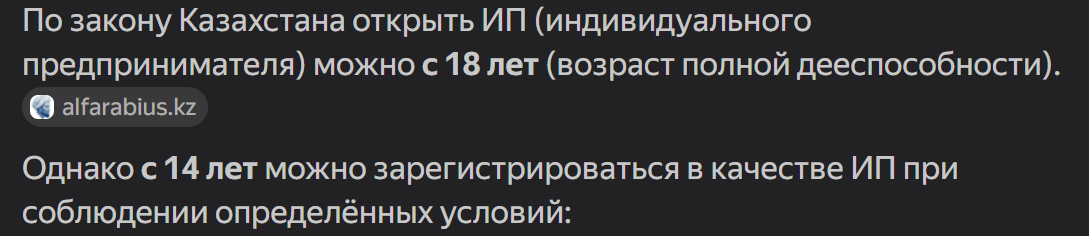

In [16]:
list(data['КРП'].unique())

[105, 120, 160, 130, 110, 115, 220, 140, 150, 215, 225, 305, 311, 310]

🚀 Данных не много их можно было бы заменить на число работников. Но это уже категория и для обучения она не помешает. **Важно помнить, что чем больше код, тем больше кол-во сотрудников**

In [17]:
data['gender'].unique()

array([ 0,  1, -1], dtype=int64)

In [18]:
print(data[data['БИН_код']== 1])

          ОКЭД  КРП       КАТО   cut_date  age  gender  БИН_код
0        47999  105  103620200 2024-05-01   26       0        1
2618465  47999  105  751910000 2022-10-01   26       0        1


🚀 Вывод:
1. Пропусков в данных нет
2. Всего строк в данных **4514701** из них уникальных значений БИН ИП  закодированных **2 924 794**. Согласно данным интернета на одно ИП только один свой уникальный БИН, даже если предприятие закрылось, то ему заново присваивают новый БИН. **Стоит отметить, что некоторые ИП меняли свой род деятельности, регион и другие параметры**
3. Пол имеет значени -1. Теория: ИП не захотел указывать свой пол.
4. Удалили возраст < 14

**Таблика close_ip**

In [19]:
null_columns = close_ip.columns
data_null(close_ip,null_columns)

Процент пропуска gender от всего датасета = 0.0
Количество уникальных значений в колонке gender: 3

Процент пропуска age_bin от всего датасета = 0.0
Количество уникальных значений в колонке age_bin: 8

Процент пропуска БИН_код от всего датасета = 0.0
Количество уникальных значений в колонке БИН_код: 1720954

Процент пропуска data_create от всего датасета = 0.0
Количество уникальных значений в колонке data_create: 74

Процент пропуска close_date от всего датасета = 0.0
Количество уникальных значений в колонке close_date: 76



In [20]:
# удаляю дубликаты
close_ip = close_ip.drop_duplicates()
print(f"Итоговое количество строк в таблице close_ip : {len(close_ip)}")

Итоговое количество строк в таблице close_ip : 1720954


**Таблица open_ip**

In [21]:
null_columns = open_ip.columns
data_null(open_ip,null_columns)

Процент пропуска gender от всего датасета = 0.0
Количество уникальных значений в колонке gender: 3

Процент пропуска age_bin от всего датасета = 0.0
Количество уникальных значений в колонке age_bin: 8

Процент пропуска БИН_код от всего датасета = 0.0
Количество уникальных значений в колонке БИН_код: 1288695

Процент пропуска data_create от всего датасета = 0.0
Количество уникальных значений в колонке data_create: 63



In [22]:
open_ip['age_bin'].unique()

array([1, 0, 7, 6, 5, 4, 3, 2], dtype=int64)

In [23]:
close_ip['age_bin'].unique()

array([1, 0, 7, 6, 5, 4, 3, 2], dtype=int64)

In [24]:
# удаляю дубликаты
open_ip = open_ip.drop_duplicates()
print(f"Итоговое количество строк в таблице open_ip: {len(open_ip)}")

Итоговое количество строк в таблице open_ip: 1288695


In [25]:
open_ip['status'] = 1
close_ip['status'] = 0

🚀 Вывод по подразделу: 
    
1. Пропусков в данных - нет 
2. Дубликаты - удалены
3. Аномальные значения - удалены(можно было бы проверить правильность и существование кодов)
4. Промаркерованы данные (status 1 открыто, 0 закрыто)

Замечено:
   * В таблице `data` некоторые ИП меняли свой род деятельности, регион и другие параметры в разное время. При объединении стоит сохранить все данные.
   * Важно помнить, что чем больше код в КРП, тем больше кол-во сотрудников.
   * Срок существования ИП схожий у закрытых и открытых ИП от 0 до 7 лет, странно.

### Объединение  таблиц, обработка, добавление признаков

In [89]:
#объядиняем данные с сохранением всех данных
final = pd.concat([close_ip, open_ip], axis=0, ignore_index=True)
final.head()

,gender,age_bin,БИН_код,data_create,close_date,status
0,-1,1,2452689,2021-09-01,2022-02-01,0
1,-1,1,1840313,2022-08-01,2024-02-01,0
2,-1,1,1962670,2022-08-01,2023-12-01,0
3,-1,1,1420141,2021-05-01,2021-06-01,0
4,-1,1,2486118,2021-10-01,2021-12-01,0


In [90]:
#теперь объединяю с другой таблицей также сохраняя все данные
final_all = pd.merge(
    final,
    data,
    on='БИН_код',
    how='outer',
    suffixes=('_ip', '_person')  # Суффиксы для одинаковых столбцов
)

In [91]:
final_all.head()

,gender_ip,age_bin,БИН_код,data_create,close_date,status,ОКЭД,КРП,КАТО,cut_date,age,gender_person
0,0,2,1,2022-09-01,NaN,1,47999,105,103620200,2024-05-01,26.0,0.0
1,0,2,1,2022-09-01,NaN,1,47999,105,751910000,2022-10-01,26.0,0.0
2,0,7,2,2018-01-01,2020-01-01,0,47910,105,103620100,2024-05-01,59.0,0.0
3,0,7,2,2018-01-01,2020-01-01,0,47712,105,633420100,2019-12-01,59.0,0.0
4,0,7,3,2018-01-01,2021-03-01,0,47822,105,103620100,2024-05-01,65.0,0.0


🚀 Окончательно буду работать с этой таблицей. Для начала ещё раз проверим на все пропуски, дубликаты, аномалии и перейдем к ЕДА.

In [92]:
null_columns = final_all.columns
data_null(final_all,null_columns)

Процент пропуска gender_ip от всего датасета = 0.0
Количество уникальных значений в колонке gender_ip: 3

Процент пропуска age_bin от всего датасета = 0.0
Количество уникальных значений в колонке age_bin: 8

Процент пропуска БИН_код от всего датасета = 0.0
Количество уникальных значений в колонке БИН_код: 3009649

Процент пропуска data_create от всего датасета = 0.0
Количество уникальных значений в колонке data_create: 75

Процент пропуска close_date от всего датасета = 43.09360948320055
Количество уникальных значений в колонке close_date: 77

Процент пропуска status от всего датасета = 0.0
Количество уникальных значений в колонке status: 2

Процент пропуска ОКЭД от всего датасета = 1.9814351518895597
Количество уникальных значений в колонке ОКЭД: 1141

Процент пропуска КРП от всего датасета = 1.9814351518895597
Количество уникальных значений в колонке КРП: 15

Процент пропуска КАТО от всего датасета = 1.9814351518895597
Количество уникальных значений в колонке КАТО: 11189

Процент про

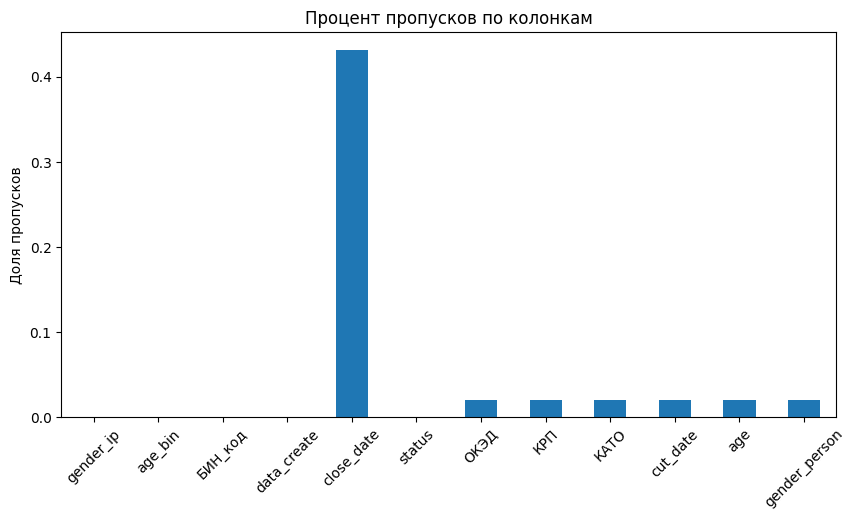

In [93]:
plt.figure(figsize=(10, 5))
final_all.isnull().mean().plot(kind='bar')
plt.title('Процент пропусков по колонкам')
plt.ylabel('Доля пропусков')
plt.xticks(rotation=45)
plt.show()

In [94]:
# удаляю пропуски
final = final_all.dropna(subset=['ОКЭД', 'КРП', 'КАТО', 'cut_date', 'age', 'gender_person'])
final['close_date'] = final['close_date'].fillna(datetime.now().date())
print(f"Удалено строк: {len(final_all) - len(final)}")

Удалено строк: 85188


🚀 Процент пропусков в колонках `ОКЭД, КРП, КАТО, cut_date, age` одинаковый: ~1.9%. Для данных было бы хорошо заполнить пропуски медианой, самым частым значением и тд. Но в связи с тем, что пропуски маленькие  - удалили. Заполнили только дату закрытия ИП сегодняшней датой.

In [95]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4214120 entries, 0 to 4299307
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   gender_ip      int64         
 1   age_bin        int64         
 2   БИН_код        int64         
 3   data_create    object        
 4   close_date     object        
 5   status         int64         
 6   ОКЭД           category      
 7   КРП            category      
 8   КАТО           category      
 9   cut_date       datetime64[ns]
 10  age            float64       
 11  gender_person  float64       
dtypes: category(3), datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 342.0+ MB


In [96]:
#меняем тип 
final['age'] = final['age'].astype('int')
final['gender_person'] = final['gender_person'].astype('int')
final['close_date'] = pd.to_datetime(final['close_date'])
final['data_create'] = pd.to_datetime(final['data_create'])

In [97]:
final = final.drop_duplicates()
print(f"Итоговое количество строк в таблице final: {len(final)}")

Итоговое количество строк в таблице final: 4214120


In [98]:
# странно, что разные gender - проверим и удалим не нужный признак
identich = (final['gender_ip'] == final['gender_person']).all()

print(f"Колонки похожи : {identich}")

Колонки похожи : True


In [99]:
final = final.drop('gender_ip', axis=1)

In [100]:
final.head(30)

,age_bin,БИН_код,data_create,close_date,status,ОКЭД,КРП,КАТО,cut_date,age,gender_person
0,2,1,2022-09-01,2025-07-11,1,47999,105,103620200,2024-05-01,26,0
1,2,1,2022-09-01,2025-07-11,1,47999,105,751910000,2022-10-01,26,0
2,7,2,2018-01-01,2020-01-01,0,47910,105,103620100,2024-05-01,59,0
3,7,2,2018-01-01,2020-01-01,0,47712,105,633420100,2019-12-01,59,0
4,7,3,2018-01-01,2021-03-01,0,47822,105,103620100,2024-05-01,65,0
5,7,3,2018-01-01,2021-03-01,0,47892,105,633420100,2022-02-01,65,0
6,7,3,2018-01-01,2021-03-01,0,47822,105,633420100,2019-09-01,65,0
7,7,4,2023-07-01,2025-07-11,1,47910,105,103620100,2024-05-01,74,0
8,5,5,2023-03-01,2025-07-11,1,10710,105,103620100,2024-05-01,41,0
9,7,6,2024-03-01,2025-07-11,1,47224,105,103620100,2024-05-01,61,0


**Добавим новые признаки**

In [101]:
final['close_month'] = final['close_date'].dt.month
final['close_year'] = final['close_date'].dt.year
final['close_day'] = final['close_date'].dt.day

final['create_month'] = final['data_create'].dt.month
final['create_year'] = final['data_create'].dt.year
#final['create_day'] = final['data_create'].dt.day

final = final.drop(['close_date','data_create'], axis=1)

In [102]:
#final['kato_region'] = final['КАТО'].astype(str).str[:2]
#final['okved_group'] = final['ОКЭД'].astype(str).str[:2]

🚀 Добавлены новые признаки по дате закрытия и дате создания. Теперь хотелось бы вытащить из данных все изменения по ОКЭД, КАТО, сколько раз по каждому БИН изменялись эти значения 

In [103]:
final.head()

,age_bin,БИН_код,status,ОКЭД,КРП,КАТО,cut_date,age,gender_person,close_month,close_year,close_day,create_month,create_year
0,2,1,1,47999,105,103620200,2024-05-01,26,0,7,2025,11,9,2022
1,2,1,1,47999,105,751910000,2022-10-01,26,0,7,2025,11,9,2022
2,7,2,0,47910,105,103620100,2024-05-01,59,0,1,2020,1,1,2018
3,7,2,0,47712,105,633420100,2019-12-01,59,0,1,2020,1,1,2018
4,7,3,0,47822,105,103620100,2024-05-01,65,0,3,2021,1,1,2018


In [109]:
# сортирую по БИН и дате среза
final = final.sort_values(by=['БИН_код', 'cut_date'])

# подсчет изменений с помощью векторизации
def calculate_changes(df):
    # Создаем столбцы для изменений
    df['kato_diff'] = df['КАТО'] != df['КАТО'].shift(1)
    df['oked_diff'] = df['ОКЭД'] != df['ОКЭД'].shift(1)
    df['krp_diff'] = df['КРП'] != df['КРП'].shift(1)

    # Учитываем, что первое значение в группе не является изменением
    df.loc[df['БИН_код'] != df['БИН_код'].shift(1), ['kato_diff', 'oked_diff', 'krp_diff']] = False

    return df

# Применяем подсчет изменений
final = calculate_changes(final)

In [110]:
# Группируем для подсчета изменений и получения последней записи
tqdm.pandas(desc="Обработка БИН_кодов")
changes = final.groupby('БИН_код')[['kato_diff', 'oked_diff', 'krp_diff']].sum().reset_index()
changes['kato_changes'] = changes['kato_diff'].astype(int)
changes['oked_changes'] = changes['oked_diff'].astype(int)
changes['krp_changes'] = changes['krp_diff'].astype(int)
changes = changes[['БИН_код', 'kato_changes', 'oked_changes', 'krp_changes']]

# Получаем последнюю запись для каждого БИН_код
last_records = final.groupby('БИН_код').last().reset_index()

# Объединяем изменения с последними записями
final = last_records.merge(changes, on='БИН_код', how='left')

# Удаляем столбец cut_date и временные столбцы, если они остались
final = result.drop(columns=['cut_date', 'kato_diff', 'oked_diff', 'krp_diff'], errors='ignore')

final.head(30)

,БИН_код,age_bin,status,ОКЭД,КРП,КАТО,age,gender_person,close_month,close_year,close_day,create_month,create_year,kato_changes,oked_changes,krp_changes
0,1,2,1,47999,105,103620200,26,0,7,2025,11,9,2022,1,0,0
1,2,7,0,47910,105,103620100,59,0,1,2020,1,1,2018,1,1,0
2,3,7,0,47822,105,103620100,65,0,3,2021,1,1,2018,1,2,0
3,4,7,1,47910,105,103620100,74,0,7,2025,11,7,2023,0,0,0
4,5,5,1,10710,105,103620100,41,0,7,2025,11,3,2023,0,0,0
5,6,7,1,47224,105,103620100,61,0,7,2025,11,3,2024,0,0,0
6,7,6,1,96020,105,103620100,47,0,7,2025,11,11,2023,0,0,0
7,9,6,0,1410,105,103620100,49,1,6,2021,1,5,2021,1,0,0
8,10,6,0,93299,105,103620100,55,0,8,2023,1,1,2018,1,1,0
9,11,7,0,68201,105,103620100,60,0,11,2020,1,9,2020,1,0,0


In [111]:
print("Количество дубликатов по БИН_код:", final['БИН_код'].duplicated().sum())
final = final.drop_duplicates(subset='БИН_код', keep='first')

Количество дубликатов по БИН_код: 0


In [112]:
#согласна данным из интернета поделим на группы КРП (численность)
final['КРП'] = final['КРП'].astype('int')
krp = final['КРП'].unique()
small = [x for x in krp if x < 160]
medium = [x for x in krp if 160 <= x < 300]
large = [x for x in krp if x >= 300]

In [113]:
print(krp)

[105 120 160 130 110 115 220 140 150 215 225 305 311]


In [114]:
def class_krp(krp):
    if krp in small:
        return 'малое'
    elif krp in medium:
        return 'среднее'
    elif krp in large:
        return 'крупное'
    else:
        return 'неизвестно'
final['ip_size'] = final['КРП'].apply(class_krp)

In [117]:
print("Доля БИН с изменением ОКЭД:", final['oked_changes'].mean())
print("Доля БИН с изменением КРП:", final['krp_changes'].mean())
print("Доля БИН с изменением КАТО:", final['kato_changes'].mean())

Доля БИН с изменением ОКЭД: 0.23446440215820966
Доля БИН с изменением КРП: 0.015257512409979138
Доля БИН с изменением КАТО: 0.2581744123105078


In [146]:
#проверю возраст (кажется группы тут и одно другое замещает)
age = final[['age', 'age_bin']].groupby('age_bin').agg(['min', 'max'])
print(age)

        age     
        min  max
age_bin         
0        14   21
1        22   25
2        26   30
3        31   35
4        36   40
5        41   45
6        46   55
7        56  100


Группировка по 5-тилетию, но группа 7 немного странная от 56 до 61 должна быть...

In [147]:
#так и есть удаляем колонку с возрастом
final = final.drop(columns=['age'], errors='ignore')

🚀  Вывод по разделу. 
1. Объеденены все таблицы, с минимальной потерей данных
2. Удалены дубликаты, пропущенные даты закрытия ИП в не закрытых ИП - заменены на настоящее время
3. Удален gender_id, так как повторял колонку gender_person
3. Добавлены новые признаки:
    * месяц и год с колонки data_create, close_data (наследовательные колонки были удалены, так как исчерпали себя)
    * добавлены колонки в которых отмечено сколько было изменений в КАТО, ОКЭД и КРП по каждому БИН
    * добавили регион КАТО, можно углубиться и разбить на город и деревни
    * добавили вид численности
    * разделили КАТО на регионы 
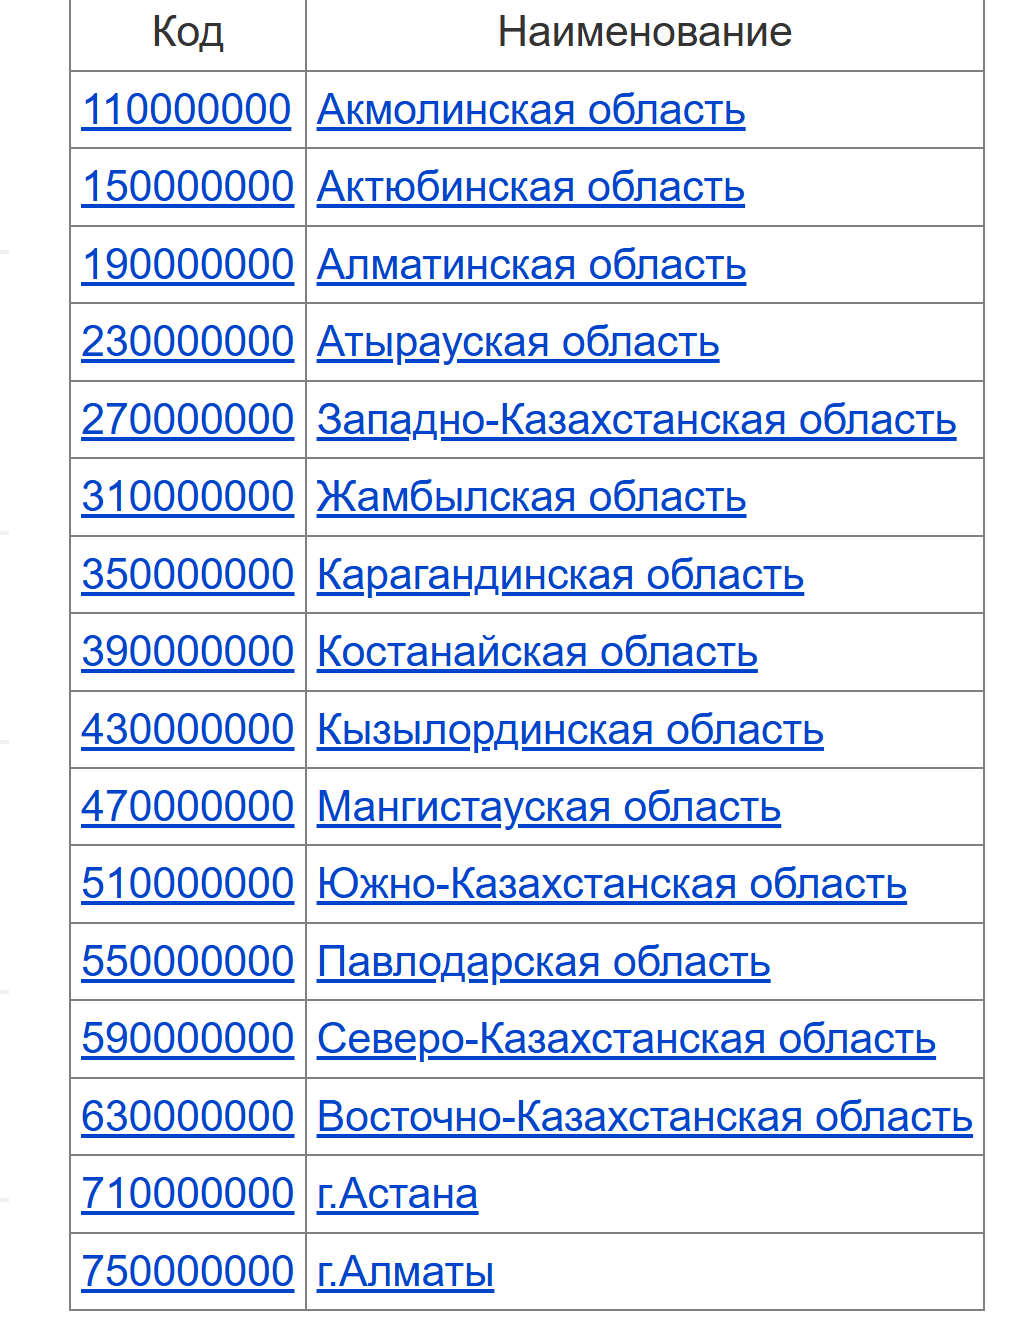

## Иследовательский анализ данных 

In [118]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924461 entries, 0 to 2924460
Data columns (total 17 columns):
 #   Column         Dtype   
---  ------         -----   
 0   БИН_код        int64   
 1   age_bin        int64   
 2   status         int64   
 3   ОКЭД           category
 4   КРП            int32   
 5   КАТО           category
 6   age            int32   
 7   gender_person  int32   
 8   close_month    int32   
 9   close_year     int32   
 10  close_day      int32   
 11  create_month   int32   
 12  create_year    int32   
 13  kato_changes   int32   
 14  oked_changes   int32   
 15  krp_changes    int32   
 16  ip_size        object  
dtypes: category(2), int32(11), int64(3), object(1)
memory usage: 223.5+ MB


🚀 Что хотелось бы посмотреть:
1. Распределение статуса ИП (активные/закрытые): Гистограмма для анализа доли активных и закрытых ИП.
2. Распределение возраста предпринимателей: Гистограмма возраста (age) с разделением по статусу ИП.
3. Динамика изменений ОКЭД, КАТО и КРП: Гистограммы для анализа частоты изменений этих параметров и их связи с устойчивостью.
4. Статус ИП по категориям возраста (age_bin): Столбчатая диаграмма для оценки устойчивости по возрастным группам.
5. Топ-10 видов деятельности (ОКЭД) по статусу: Столбчатая диаграмма для анализа, какие виды деятельности чаще связаны с активными или закрытыми ИП.
6. Статус ИП по регионам (КАТО): Столбчатая диаграмма для анализа устойчивости по регионам.

### Анализ ИП по дате закрытия

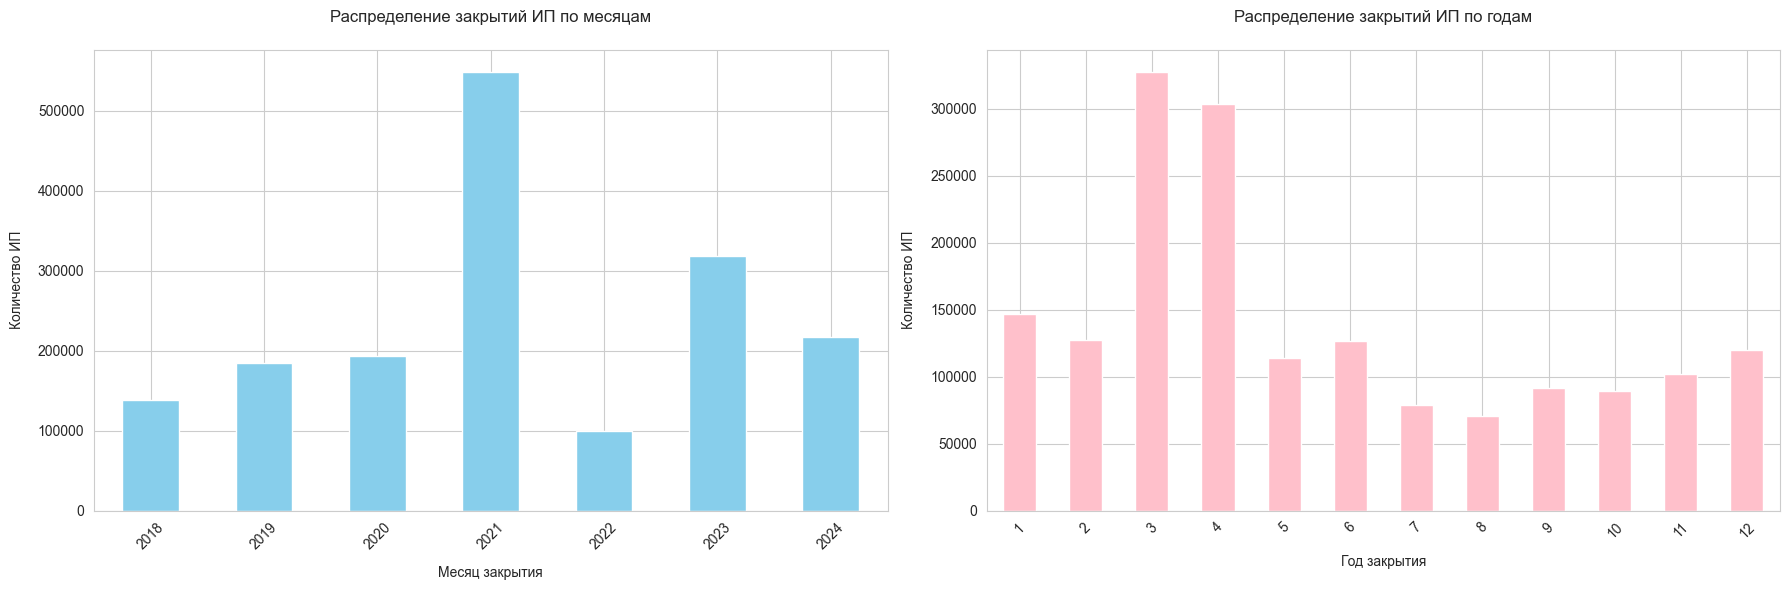

In [152]:
plt.figure(figsize=(18, 6))

# по месяцам
plt.subplot(1, 2, 1)
final[final['status'] == 0]['close_year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение закрытий ИП по месяцам', pad=20)
plt.xlabel('Месяц закрытия', labelpad=10)
plt.ylabel('Количество ИП', labelpad=10)
plt.xticks(rotation=45)

# по годам
plt.subplot(1, 2, 2)  
final[final['status'] == 0]['close_month'].value_counts().sort_index().plot(kind='bar', color='pink')
plt.title('Распределение закрытий ИП по годам', pad=20)
plt.xlabel('Год закрытия', labelpad=10)
plt.ylabel('Количество ИП', labelpad=10)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

🚀 Основной пик закрытия ИП пришлось на **2021 год. и на март и апрель**. Скорее всего после короновируса, некоторые ИП не смогли перестроиться.

### Распределение статуса ИП

Цель: Показать общее соотношение активных и закрытых ИП.
При высокой доли закрытых ИП можно сказать, что ИП в Казахстане имеют низскую устойчивость.

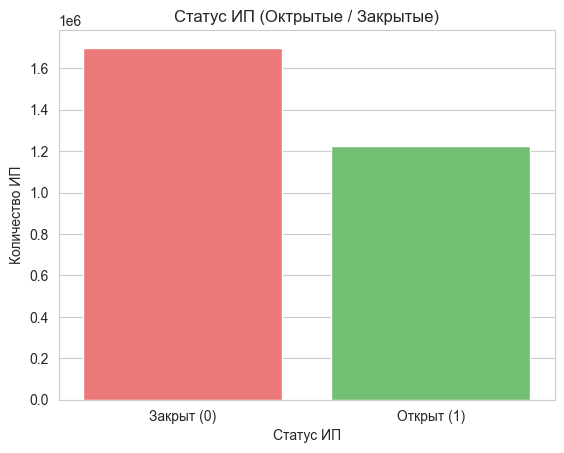

In [153]:
sns.countplot(data=final, x='status', palette={0: '#FF6666', 1: '#66CC66'})
plt.title('Статус ИП (Октрытые / Закрытые)')
plt.xlabel('Статус ИП')
plt.ylabel('Количество ИП')
plt.xticks(ticks=[0, 1], labels=['Закрыт (0)', 'Открыт (1)'])
plt.savefig('ip.png')
plt.show()

🚀 Закрытых ИП больше. Следовательно В Казахстане существует низская устойчивость ИП.

### Распределение возраста предпринимателей

In [ ]:
Цель: посмотреть влияет ли возраст на закрытие ИП.

<Figure size 1000x500 with 0 Axes>

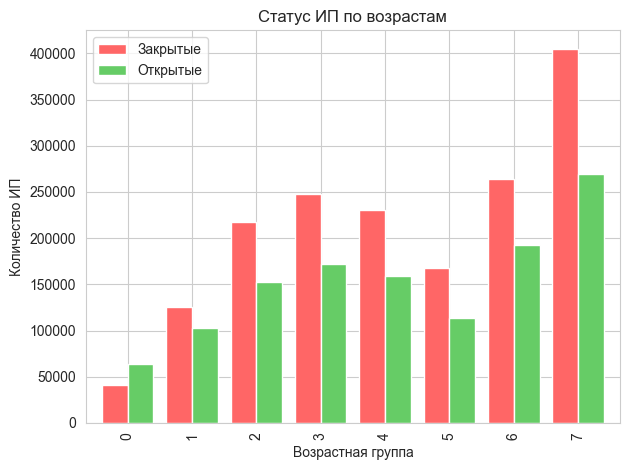

In [154]:
status_counts = final.groupby(['age_bin', 'status']).size().unstack()
plt.figure(figsize=(10, 5))
status_counts.plot(kind='bar', 
                 color=['#FF6666', '#66CC66'],
                 width=0.8)
plt.title('Статус ИП по возрастам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество ИП')
plt.legend(['Закрытые', 'Открытые'])
plt.savefig('age.png')
plt.tight_layout()
plt.show()

🚀 Пик предпринимательской активности приходится на средний возраст (3-4 группа слева)
 Интересный факт, что люди в возрастной категории от 54 до 100 закрывают бизнес чаще и так же имеют пик по открытым ИП. Это логично ведь устойчивый бизнес со своей базой клиентов должен устойчивее находиться на рынке. Но в тоже время возраст влияет на занятие трудовой деятельностью.

### График топ-10 видов деятельности (ОКЭД)

Цель: чтобы выявить, какие виды деятельности менее устойчивы

C:\Users\Admin\anaconda3\envs\new_env\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Admin\anaconda3\envs\new_env\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


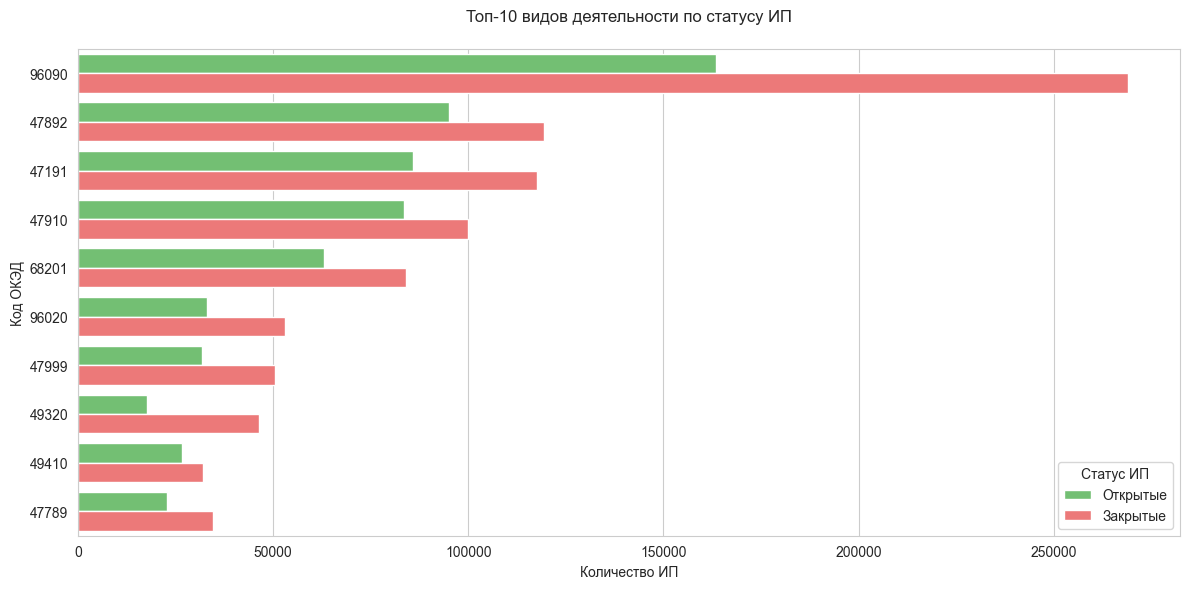

In [155]:
top_okeds = final['ОКЭД'].value_counts().head(10).index

# 2. Фильтруем данные
oked_data = final[final['ОКЭД'].isin(top_okeds)].copy()
oked_data['Статус'] = oked_data['status'].map({0: 'Закрытые', 1: 'Открытые'})

plt.figure(figsize=(12, 6))
sns.countplot(data=oked_data, y='ОКЭД', hue='Статус', palette={'Открытые': '#66CC66', 'Закрытые': '#FF6666'},order=top_okeds)
plt.title('Топ-10 видов деятельности по статусу ИП', pad=20)
plt.xlabel('Количество ИП')
plt.ylabel('Код ОКЭД')
plt.legend(title='Статус ИП')
plt.savefig('top_okeds.png')
plt.tight_layout()
plt.show()

🚀Коды ОКЭД 96090 (предоставление прочих услуг, не включенных в другие группировки), 47892, 47191, 47910 и 68201 имеют наименьшую устойчивость на рынке

### Топ-10 регионов (КАТО)
 Цель: чтобы оценить устойчивость ИП по регионам

C:\Users\Admin\anaconda3\envs\new_env\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Admin\anaconda3\envs\new_env\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


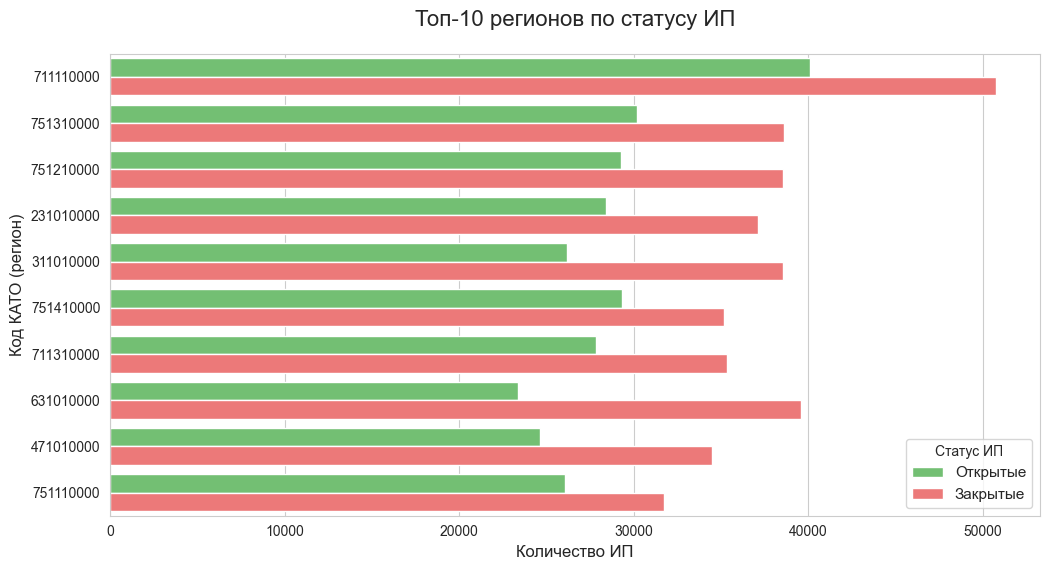

In [156]:
top_katos = final['КАТО'].value_counts().head(10).index
kato_data = final[final['КАТО'].isin(top_katos)].copy()
kato_data['Статус'] = kato_data['status'].map({0: 'Закрытые', 1: 'Открытые'})

plt.figure(figsize=(12, 6))
sns.countplot(
    data=kato_data,
    y='КАТО',
    hue='Статус',
    palette={'Открытые': '#66CC66', 'Закрытые': '#FF6666'},
    order=top_katos  
)
plt.title('Топ-10 регионов по статусу ИП', fontsize=16, pad=20)
plt.xlabel('Количество ИП', fontsize=12)
plt.ylabel('Код КАТО (регион)', fontsize=12)
plt.legend(title='Статус ИП', fontsize=11)
plt.savefig('top_kato.png')
plt.show()

🚀  График показывает концентрацию ИП в крупных городах (Алматы, Шымкент, Астана), где бизнес-активность максимальна. Но так же сильная неустойчивость бизнеса в Астане.

### Динамика изменений ОКЭД, КАТО и КРП

In [ ]:
Цель: посмотреть как часто ИП меняют регион (КАТО), вид деятельности (ОКЭД) или размер (КРП).
Если ИП часто меняют ОКЭД, это может значить, что они не находят стабильный бизнес.

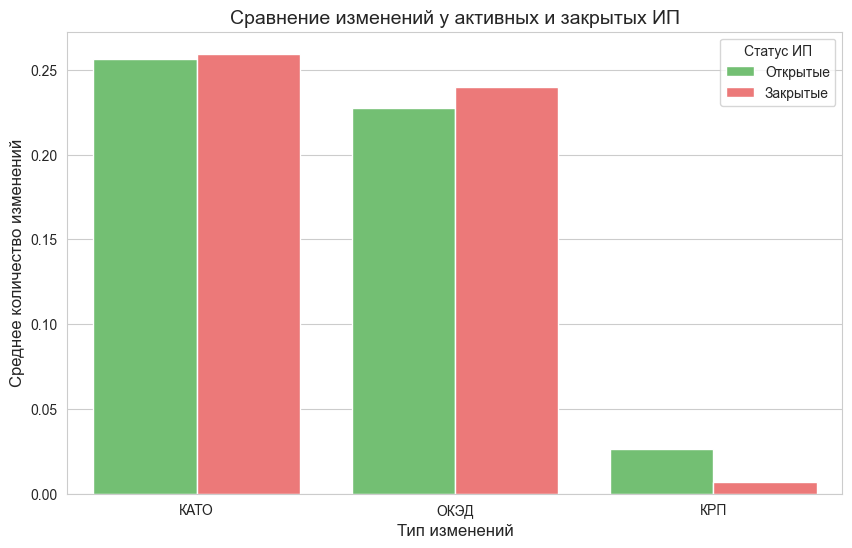

In [157]:
active_ips = final[final['status'] == 1]
closed_ips = final[final['status'] == 0]

# Корректная подготовка данных
changes_data = pd.DataFrame({
    'Тип изменений': ['КАТО']*2 + ['ОКЭД']*2 + ['КРП']*2,
    'Статус ИП': ['Открытые', 'Закрытые'] * 3,
    'Среднее количество изменений': [
        active_ips['kato_changes'].mean(),
        closed_ips['kato_changes'].mean(),
        active_ips['oked_changes'].mean(),
        closed_ips['oked_changes'].mean(),
        active_ips['krp_changes'].mean(),
        closed_ips['krp_changes'].mean()
    ]
})
plt.figure(figsize=(10, 6))
sns.barplot(
    data=changes_data,
    x='Тип изменений',
    y='Среднее количество изменений',
    hue='Статус ИП',
    palette={'Открытые': '#66CC66', 'Закрытые': '#FF6666'}
)

plt.title('Сравнение изменений у активных и закрытых ИП', fontsize=14)
plt.xlabel('Тип изменений', fontsize=12)
plt.ylabel('Среднее количество изменений', fontsize=12)
plt.legend(title='Статус ИП')
plt.savefig('diff.png')
plt.show()

🚀Закрытые ИП имеют чуть больше изменений по всем категориям (столбцы выше), особенно заметно для КАТО (региона). Активные ИП демонстрируют минимальные изменения, это логично для стабильно работающего бизнеса.

**Вывод:**
   1. ИП в старших группах (55+) чаще закрываются, возможно из-за выхода на пенсию или проблем со здоровьем
   2. Популярные сферы (например, 96090) имеют высокую конкуренцию и текучесть, что снижает устойчивость
   3. В активных регионах (например, 771110000, 71111000) больше закрытий, что может быть связано с конкуренцией или экономическими условиями.
   4. Частые изменения ОКЭД коррелируют с закрытием ИП, указывая на нестабильность